The `3-xGModel.py` code is designed to analyze soccer shot data from the Wyscout dataset to understand shooting patterns, including shot locations, goals, and the probability of scoring from different positions on the field (xG). Let's break down the code into sections and add comments for better understanding.

### Import Libraries

In [2]:
# Import necessary libraries for data manipulation, statistical analysis, and plotting
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import FCPython  # Custom library for football analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Load Data

In [3]:
# Load event data for the English league from a JSON file
with open('Wyscout/events/events_Italy.json') as f:
    data = json.load(f)

In [4]:
data

[{'eventId': 8,
  'subEventName': 'Simple pass',
  'tags': [{'id': 1801}],
  'playerId': 8327,
  'positions': [{'y': 52, 'x': 49}, {'y': 44, 'x': 43}],
  'matchId': 2575959,
  'eventName': 'Pass',
  'teamId': 3158,
  'matchPeriod': '1H',
  'eventSec': 2.5305359999999837,
  'subEventId': 85,
  'id': 180423957},
 {'eventId': 8,
  'subEventName': 'Simple pass',
  'tags': [{'id': 1801}],
  'playerId': 20438,
  'positions': [{'y': 44, 'x': 43}, {'y': 17, 'x': 36}],
  'matchId': 2575959,
  'eventName': 'Pass',
  'teamId': 3158,
  'matchPeriod': '1H',
  'eventSec': 3.768417999999997,
  'subEventId': 85,
  'id': 180423958},
 {'eventId': 7,
  'subEventName': 'Touch',
  'tags': [],
  'playerId': 8306,
  'positions': [{'y': 17, 'x': 36}, {'y': 56, 'x': 78}],
  'matchId': 2575959,
  'eventName': 'Others on the ball',
  'teamId': 3158,
  'matchPeriod': '1H',
  'eventSec': 4.868265000000008,
  'subEventId': 72,
  'id': 180423959},
 {'eventId': 1,
  'subEventName': 'Ground attacking duel',
  'tags': 

### Initialize the Shots Data Frame for building the Model

This section of the code is dedicated to processing soccer shot event data to prepare for building the xGModel. The goal is to create a dataset that captures the details of each shot, including its location, whether it was a header, the distance from the goal, the angle of the shot, and whether it resulted in a goal.

In [5]:
# Convert the raw data into a pandas DataFrame for easier data manipulation
train = pd.DataFrame(data) # event data

In [6]:
train

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],8327,"[{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]",2575959,Pass,3158,1H,2.530536,85,180423957
1,8,Simple pass,[{'id': 1801}],20438,"[{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]",2575959,Pass,3158,1H,3.768418,85,180423958
2,7,Touch,[],8306,"[{'y': 17, 'x': 36}, {'y': 56, 'x': 78}]",2575959,Others on the ball,3158,1H,4.868265,72,180423959
3,1,Ground attacking duel,"[{'id': 504}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 56, 'x': 78}, {'y': 15, 'x': 64}]",2575959,Duel,3158,1H,8.114676,11,180423960
4,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 15, 'x': 64}, {'y': 15, 'x': 72}]",2575959,Duel,3158,1H,8.647892,11,180423961
...,...,...,...,...,...,...,...,...,...,...,...,...
647367,3,Free kick cross,"[{'id': 801}, {'id': 1801}]",70974,"[{'y': 23, 'x': 75}, {'y': 65, 'x': 95}]",2576338,Free Kick,3193,2H,2870.982660,32,253567160
647368,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",14745,"[{'y': 35, 'x': 5}, {'y': 36, 'x': 3}]",2576338,Duel,3185,2H,2872.101142,13,253567161
647369,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",413041,"[{'y': 65, 'x': 95}, {'y': 64, 'x': 97}]",2576338,Duel,3193,2H,2872.990437,13,253567163
647370,1,Air duel,"[{'id': 703}, {'id': 1801}]",20927,"[{'y': 36, 'x': 3}, {'y': 100, 'x': 100}]",2576338,Duel,3185,2H,2874.049206,10,253567162


In [7]:
# Extract unique sub-event names to identify different types of events
pd.unique(train['subEventName'])

array(['Simple pass', 'Touch', 'Ground attacking duel',
       'Ground defending duel', 'Ground loose ball duel', 'Foul',
       'Free Kick', 'Cross', 'Ball out of the field', 'Goal kick',
       'Air duel', 'Smart pass', 'Clearance', 'Throw in', 'High pass',
       'Head pass', 'Shot', 'Save attempt', 'Hand pass', '',
       'Acceleration', 'Launch', 'Corner', 'Free kick shot', 'Reflexes',
       'Free kick cross', 'Goalkeeper leaving line', 'Hand foul',
       'Penalty', 'Protest', 'Whistle', 'Late card foul',
       'Time lost foul', 'Out of game foul', 'Simulation', 'Violent Foul'],
      dtype=object)

In [24]:
# Filter the dataset to only include events classified as 'Shot'
shots = train[train['subEventName'] == 'Shot']

### Exploring Shots



In [23]:
shots

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
68,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1203}, {'id'...",21077,"[{'y': 41, 'x': 80}, {'y': 0, 'x': 0}]",2575959,Shot,3172,1H,193.924279,100,180424028
90,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1210}, {'id'...",8327,"[{'y': 33, 'x': 95}, {'y': 100, 'x': 100}]",2575959,Shot,3158,1H,250.843152,100,180424079
213,10,Shot,"[{'id': 402}, {'id': 2101}, {'id': 1802}]",20879,"[{'y': 63, 'x': 72}, {'y': 100, 'x': 100}]",2575959,Shot,3158,1H,633.577774,100,180424208
426,10,Shot,"[{'id': 1901}, {'id': 402}, {'id': 201}, {'id'...",23149,"[{'y': 62, 'x': 91}, {'y': 100, 'x': 100}]",2575959,Shot,3158,1H,1359.469422,100,180424444
435,10,Shot,"[{'id': 1901}, {'id': 401}, {'id': 1216}, {'id...",295176,"[{'y': 26, 'x': 86}, {'y': 0, 'x': 0}]",2575959,Shot,3172,1H,1412.601525,100,180424409
...,...,...,...,...,...,...,...,...,...,...,...,...
646870,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'...",116269,"[{'y': 45, 'x': 95}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,1152.032980,100,253566542
646904,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1212}, {'id'...",3548,"[{'y': 38, 'x': 93}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,1251.730517,100,253566586
647169,10,Shot,"[{'id': 101}, {'id': 401}, {'id': 201}, {'id':...",21177,"[{'y': 46, 'x': 90}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,2065.034482,100,253566910
647218,10,Shot,"[{'id': 402}, {'id': 1212}, {'id': 1802}]",349102,"[{'y': 32, 'x': 79}, {'y': 0, 'x': 0}]",2576338,Shot,3193,2H,2367.252041,100,253566961


In [32]:
shots.columns

Index(['eventId', 'subEventName', 'tags', 'playerId', 'positions', 'matchId',
       'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id'],
      dtype='object')

Examine a Single Shot:

In [51]:
shots.iloc[0] # a shot

eventId                                                        10
subEventName                                                 Shot
tags            [{'id': 402}, {'id': 201}, {'id': 1203}, {'id'...
playerId                                                    21077
positions                  [{'y': 41, 'x': 80}, {'y': 0, 'x': 0}]
matchId                                                   2575959
eventName                                                    Shot
teamId                                                       3172
matchPeriod                                                    1H
eventSec                                               193.924279
subEventId                                                    100
id                                                      180424028
Name: 68, dtype: object

This will show you the structure of a shot event, including the `tags` field.

Let's see which tags involve this shot:

In [52]:
shots.iloc[0]['tags']

[{'id': 402}, {'id': 201}, {'id': 1203}, {'id': 1801}]

To better understand what shot tags are and explore the shots data more effectively, we can start by examining the structure of the shots data, particularly focusing on the `tags` field. In the Wyscout data, each event (including shots) is annotated with tags. These tags are numerical codes that provide additional information about the event, such as whether a shot was a goal, a header, part of a set piece, and so on.

### Understanding Shot Tags

Each tag in the Wyscout dataset has a unique identifier that describes a specific characteristic or outcome of the event. For example:
- `101` indicates that the shot resulted in a goal.
- `403` indicates that the shot was a header.

These tags allow us to analyze and filter shots based on their outcomes and characteristics, enhancing our understanding of shooting effectiveness and tendencies within the dataset.

Here the only documentation available I could find about the tags id and relative labels .

https://support.wyscout.com/matches-wyid-events

In [53]:
def map_tag_id_to_label(tag_id):
    tag_id_to_label = {
        101: "Goal",
        102: "Own goal",
        301: "Assist",
        302: "Key pass",
        1901: "Counter attack",
        401: "Left",
        402: "Right",
        403: "Head/body",
        1101: "Direct",
        1102: "Indirect",
        2001: "Dangerous ball lost",
        2101: "Blocked",
        801: "High",
        802: "Low",
        1401: "Interception",
        1501: "Clearance",
        201: "Opportunity",
        1301: "Feint",
        1302: "Missed ball",
        501: "Free space right",
        502: "Free space left",
        503: "Take on left",
        504: "Take on right",
        1601: "Sliding tackle",
        601: "Anticipated",
        602: "Anticipation",
        1701: "Red card",
        1702: "Yellow card",
        1703: "Second yellow card",
        1201: "Position: Goal low center",
        1202: "Position: Goal low right",
        1203: "Position: Goal center",
        1204: "Position: Goal center left",
        1205: "Position: Goal low left",
        1206: "Position: Goal center right",
        1207: "Position: Goal high center",
        1208: "Position: Goal high left",
        1209: "Position: Goal high right",
        1210: "Position: Out low right",
        1211: "Position: Out center left",
        1212: "Position: Out low left",
        1213: "Position: Out center right",
        1214: "Position: Out high center",
        1215: "Position: Out high left",
        1216: "Position: Out high right",
        1217: "Position: Post low right",
        1218: "Position: Post center left",
        1219: "Position: Post low left",
        1220: "Position: Post center right",
        1221: "Position: Post high center",
        1222: "Position: Post high left",
        1223: "Position: Post high right",
        901: "Through",
        1001: "Fairplay",
        701: "Lost",
        702: "Neutral",
        703: "Won",
        1801: "Accurate",
        1802: "Not accurate",
    }

    # Return the label if found, else return a placeholder indicating the tag is unknown
    return tag_id_to_label.get(tag_id, "Unknown tag")

In [63]:
print(map_tag_id_to_label(101))  # Output: Goal
print(map_tag_id_to_label(402))  # Output: Right foot
print(map_tag_id_to_label(9999)) # Output: Unknown tag

Goal
Right
Unknown tag


Let's now print what tags event are associated with the first shot in the dataframe:

In [60]:
a_shot_tags_list = shots.iloc[0]['tags']

labels_list = [map_tag_id_to_label(tag['id']) for tag in a_shot_tags_list]

print(labels_list)

['Right', 'Opportunity', 'Position: Goal center', 'Accurate']


We can see the labels associated with the tags id about this shot. It was an "Opportunity" with the "Right foot" toward the "Center of the Goal" with an "Accurate" shot.

**List Unique Tags**: To understand what types of tags are associated with shots, you can aggregate all tags used in the shot events and list the unique ones:

This will give you a set of all unique tag IDs associated with shots.

In [41]:
unique_tags = set()
for _, shot in shots.iterrows():
    for tag in shot['tags']:
        unique_tags.add(tag['id'])
print(unique_tags)

{1801, 1802, 401, 402, 403, 301, 302, 1201, 1202, 1203, 1204, 2101, 1206, 1205, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1207, 1218, 1220, 1221, 1222, 1223, 1219, 201, 101, 1901, 1401}


In [55]:
# Map each unique tag ID to its label
mapped_tags = [map_tag_id_to_label(tag_id) for tag_id in unique_tags]

# Print the mapped tags
print(mapped_tags)

['Accurate', 'Not accurate', 'Left', 'Right', 'Head/body', 'Assist', 'Key pass', 'Position: Goal low center', 'Position: Goal low right', 'Position: Goal center', 'Position: Goal center left', 'Blocked', 'Position: Goal center right', 'Position: Goal low left', 'Position: Goal high left', 'Position: Goal high right', 'Position: Out low right', 'Position: Out center left', 'Position: Out low left', 'Position: Out center right', 'Position: Out high center', 'Position: Out high left', 'Position: Out high right', 'Position: Post low right', 'Position: Goal high center', 'Position: Post center left', 'Position: Post center right', 'Position: Post high center', 'Position: Post high left', 'Position: Post high right', 'Position: Post low left', 'Opportunity', 'Goal', 'Counter attack', 'Interception']


**Analyze Tag Frequencies**: To see how common each tag is, you can create a frequency distribution of the tags:

This provides insight into the most and least common shot characteristics.


In [65]:
from collections import Counter

# Assuming 'shots' is your DataFrame and 'tags' is a column containing lists of tag dictionaries
tag_counts = Counter()

for _, shot in shots.iterrows():
    for tag in shot['tags']:
        # Convert tag ID to label
        label = map_tag_id_to_label(tag['id'])
        tag_counts[label] += 1

# Print the counts of each tag label
for label, count in tag_counts.items():
    print(f"{label}: {count}")


Right: 4468
Opportunity: 6051
Position: Goal center: 483
Accurate: 3069
Left: 2970
Position: Out low right: 574
Not accurate: 5737
Blocked: 2063
Counter attack: 477
Position: Out high right: 797
Position: Goal low center: 817
Position: Out high center: 423
Head/body: 1368
Position: Out low left: 654
Position: Out high left: 687
Position: Goal center right: 251
Position: Goal low left: 516
Position: Post center right: 13
Position: Out center right: 185
Position: Post low right: 26
Goal: 853
Position: Goal high right: 99
Position: Goal low right: 416
Position: Post high center: 27
Position: Out center left: 177
Position: Goal high left: 82
Position: Goal center left: 237
Position: Goal high center: 168
Position: Post center left: 18
Position: Post high left: 28
Interception: 59
Position: Post high right: 36
Position: Post low left: 29
Assist: 2
Key pass: 4


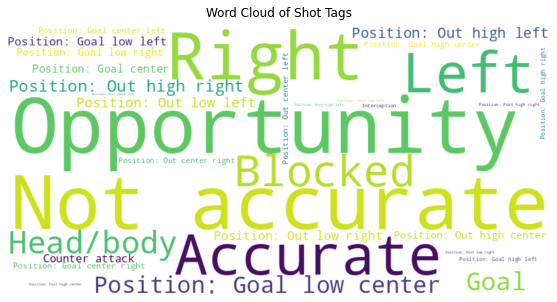

In [66]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_counts)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Shot Tags')
plt.show()

**Filter Shots by Specific Tags**: If you're interested in analyzing specific types of shots, such as goals, you can filter the dataset by the relevant tag:

This filters the shots to only those that resulted in goals.


In [64]:
goals = shots[shots['tags'].apply(lambda tags: any(tag['id'] == 101 for tag in tags))]
print(f"Number of goals: {len(goals)}")

Number of goals: 853


### Initialize a DataFrame to hold model data with specified columns

In [67]:
# Initialize a new DataFrame to store processed shot data with specific columns
shots_model = pd.DataFrame(columns=['Goal', 'X', 'Y'])

shots_model

,Goal,X,Y


### Feature Engineering:
The loop iterates through each row in the `shots` DataFrame, processing data to extract and calculate relevant information for each shot.

- Iterates through each shot event to calculate and assign new features:
  - **Header**: Identifies if the shot was a header and excludes it if so.
  - **X, Y Coordinates**: Transforms the shot's position data into X (distance from the goal line) and Y (lateral position across the field) coordinates.
  - **Distance**: Calculates the shot's distance from the goal using the Pythagorean theorem.
  - **Angle**: Calculates the shot's angle using trigonometry, considering the goal's width.
  - **Goal**: Marks if the shot resulted in a goal.

In [69]:
for i, shot in shots.iterrows():
    
    header = 0
    # Check if the shot is a header by looking through its tags
    for shottags in shot['tags']:
        if shottags['id'] == 403:
            header = 1
    
    # Process only non-header shots
    if not(header):
        # Calculate the X coordinate (the distance from the goal line) and adjust it based on the field dimensions (100 units wide)
        shots_model.at[i, 'X'] = 100 - shot['positions'][0]['x']
        # Y coordinate is simply the position on the pitch, no adjustment needed
        shots_model.at[i, 'Y'] = shot['positions'][0]['y']
        # C is the absolute vertical distance from the center line (to calculate angle later)
        shots_model.at[i, 'C'] = abs(shot['positions'][0]['y'] - 50)


In [70]:
shots_model

,Goal,X,Y,C
68,NaN,20,41,9.0
90,NaN,5,33,17.0
213,NaN,28,63,13.0
426,NaN,9,62,12.0
435,NaN,14,26,24.0
...,...,...,...,...
646870,NaN,5,45,5.0
646904,NaN,7,38,12.0
647169,NaN,10,46,4.0
647218,NaN,21,32,18.0


### Calculate Distance and Angle
The distance from the goal and the angle of the shot are calculated using the positions. The goal width is considered to be 7.32 meters, which is the standard for a football goal.

In [71]:
        # Convert X and C to real-world measures (field is 105m long and 68m wide, but we use 65m for simplicity)
        x = shots_model.at[i, 'X'] * 105 / 100
        y = shots_model.at[i, 'C'] * 65 / 100

        # Distance to the goal in meters
        shots_model.at[i, 'Distance'] = np.sqrt(x**2 + y**2)

        # Angle calculation, with correction if the angle is negative
        a = np.arctan(7.32 * x / (x**2 + y**2 - (7.32/2)**2))
        if a < 0:
            a = np.pi + a
        shots_model.at[i, 'Angle'] = a


In [72]:
shots_model

,Goal,X,Y,C,Distance,Angle
68,NaN,20,41,9.0,NaN,NaN
90,NaN,5,33,17.0,NaN,NaN
213,NaN,28,63,13.0,NaN,NaN
426,NaN,9,62,12.0,NaN,NaN
435,NaN,14,26,24.0,NaN,NaN
...,...,...,...,...,...,...
646870,NaN,5,45,5.0,NaN,NaN
646904,NaN,7,38,12.0,NaN,NaN
647169,NaN,10,46,4.0,NaN,NaN
647218,NaN,21,32,18.0,NaN,NaN


### Determine Goal Outcome
Each shot is checked to see if it resulted in a goal by examining its tags. A specific tag (id=101) is used to indicate a goal.

In [73]:
        # Initialize the 'Goal' column to 0 (no goal)
        shots_model.at[i, 'Goal'] = 0
        # Check each tag to see if it indicates a goal was scored
        for shottags in shot['tags']:
            if shottags['id'] == 101:
                shots_model.at[i, 'Goal'] = 1


In [74]:
shots_model

,Goal,X,Y,C,Distance,Angle
68,NaN,20,41,9.0,NaN,NaN
90,NaN,5,33,17.0,NaN,NaN
213,NaN,28,63,13.0,NaN,NaN
426,NaN,9,62,12.0,NaN,NaN
435,NaN,14,26,24.0,NaN,NaN
...,...,...,...,...,...,...
646870,NaN,5,45,5.0,NaN,NaN
646904,NaN,7,38,12.0,NaN,NaN
647169,NaN,10,46,4.0,NaN,NaN
647218,NaN,21,32,18.0,NaN,NaN


### Build xGModel

In [83]:
for i, shot in shots.iterrows():
    
    header = 0
    # Check if the shot is a header by looking through its tags
    for shottags in shot['tags']:
        if shottags['id'] == 403:
            header = 1
    
    # Process only non-header shots
    if not(header):
        # Calculate the X coordinate (the distance from the goal line) and adjust it based on the field dimensions (100 units wide)
        shots_model.at[i, 'X'] = 100 - shot['positions'][0]['x']
        # Y coordinate is simply the position on the pitch, no adjustment needed
        shots_model.at[i, 'Y'] = shot['positions'][0]['y']
        # C is the absolute vertical distance from the center line (to calculate angle later)
        shots_model.at[i, 'C'] = abs(shot['positions'][0]['y'] - 50)

        # Convert X and C to real-world measures (field is 105m long and 68m wide, but we use 65m for simplicity)
        x = shots_model.at[i, 'X'] * 105 / 100
        y = shots_model.at[i, 'C'] * 65 / 100

        # Distance to the goal in meters
        shots_model.at[i, 'Distance'] = np.sqrt(x**2 + y**2)

        # Angle calculation, with correction if the angle is negative
        a = np.arctan(7.32 * x / (x**2 + y**2 - (7.32/2)**2))
        if a < 0:
            a = np.pi + a
        shots_model.at[i, 'Angle'] = a

        #Was it a goal
        # Initialize the 'Goal' column to 0 (no goal)
        shots_model.at[i, 'Goal'] = 0
        # Check each tag to see if it indicates a goal was scored
        for shottags in shot['tags']:
            if shottags['id'] == 101:
                shots_model.at[i, 'Goal'] = 1

In [84]:
shots_model

,Goal,X,Y,C,Distance,Angle
68,0,20,41,9.0,21.799599,0.321317
90,0,5,33,17.0,12.233765,0.274876
213,0,28,63,13.0,30.590235,0.229221
426,0,9,62,12.0,12.253265,0.468320
435,0,14,26,24.0,21.434785,0.236713
...,...,...,...,...,...,...
646870,0,5,45,5.0,6.174545,0.999010
646904,0,7,38,12.0,10.717392,0.487547
647169,1,10,46,4.0,10.817116,0.638225
647218,0,21,32,18.0,24.961821,0.258795


### Create Histograms
The code creates two-dimensional histograms for shots and goals using the calculated X and Y positions.

In [85]:
# Create histograms for all shots and goals only
H_Shot = np.histogram2d(shots_model['X'], shots_model['Y'], bins=50, range=[[0, 100], [0, 100]])
goals_only = shots_model[shots_model['Goal'] == 1]
H_Goal = np.histogram2d(goals_only['X'], goals_only['Y'], bins=50, range=[[0, 100], [0, 100]])

### Plotting
The code uses a custom library `FCPython` to create pitch visualizations for the number of shots, number of goals, and the probability of scoring from different positions.
```python
# Ensure the Output directory exists to save plots
import os
if not os.path.exists('Output'):
    os.makedirs('Output')

# Plotting code for number of shots, number of goals, and probability of scoring
# Each block initializes a pitch layout, overlays the histogram data, adds a color bar, sets the title, and adjusts layout and aspect ratio before displaying and saving the plot
```

Each plotting section follows a similar structure:
1. Initialize the goal mouth figure using `FCPython.createGoalMouth()`.
2. Use `ax.imshow` to overlay the histogram data on the pitch figure.
3. Add a color bar for reference.
4. Set the title to describe the plot.
5. Adjust the layout and aspect ratio for better visualization.
6. Display the plot using `plt.show()`.
7. Save the figure to the "Output" folder with a descriptive filename.

This analysis provides valuable insights into shooting efficiency and goal probability from different field positions, assisting teams and analysts in strategizing and improving performance.

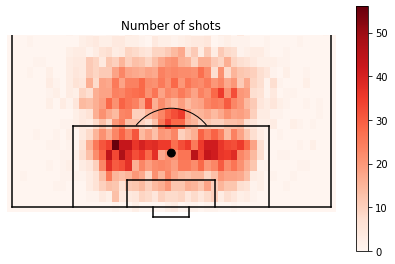

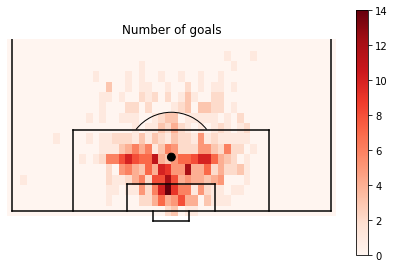

/var/folders/p6/h_lrqd2j2s928n737d4n28s80000gn/T/ipykernel_82789/1817173336.py:29: RuntimeWarning: invalid value encountered in divide
  pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)


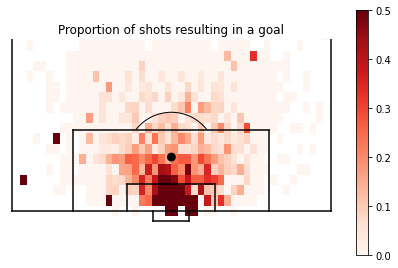

In [86]:
#Plot the number of shots from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of shots')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
fig.savefig('Output/NumberOfShots.pdf', dpi=None, bbox_inches="tight")   


#Plot the number of GOALS from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of goals')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
fig.savefig('Output/NumberOfGoals.pdf', dpi=None, bbox_inches="tight")   


#Plot the probability of scoring from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0]/H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax)
ax.set_title('Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
fig.savefig('Output/ProbabilityOfScoring.pdf', dpi=None, bbox_inches="tight")   

